# Tests with Jake's Gatspy code.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from gatspy import periodic
import rubin_rotation as rr

from isochrones import get_ichrone
from isochrones.mist.bc import MISTBolometricCorrectionGrid

plotpar = {'axes.labelsize': 30,
                  'font.size': 22,
                  'legend.fontsize': 25,
                  'xtick.labelsize': 30,
                  'ytick.labelsize': 30,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

In [3]:
bc_grid = MISTBolometricCorrectionGrid(['u', 'g', 'r', 'i', 'z', 'V'])
lsst_Mags = bc_grid.interp([5770, 4.44, 0.0, 0.], ['u', 'g', 'r', 'i', 'z', 'V'])
print(lsst_Mags)
print(bc_grid.interp([3500, 5., 0.0, 0.], ['u', 'g', 'r', 'i', 'z', 'V']))

[-1.60267731 -0.34289131  0.11412847  0.22001478  0.23366576 -0.03001813]
[-5.056717 -2.512921 -1.066977 -0.151169  0.411384 -1.61669 ]


In [22]:
def convert_mag_to_flux(delta_m):
    return 10**(.4 * delta_m)

def convert_flux_to_mag(f2f1):
    return np.log10(f2f1)/.4

def distance_modulus(D):
    return 5*np.log10(D) - 5

mag = 1e-2
print(convert_flux_to_mag(convert_mag_to_flux(mag)), convert_mag_to_flux(mag), mag)
print(f"100 mmags is a {(convert_mag_to_flux(mag)-1) * 100 :.0f}% flux variation")

D = 50000
lsst_mags = distance_modulus(D) + lsst_Mags
print(lsst_mags)
uband, gband, rband, iband, zband, Vband = lsst_mags

0.0100000000000001 1.0092528860766845 0.01
100 mmags is a 1% flux variation
[16.89217271 18.15195871 18.60897849 18.71486481 18.72851578 18.46483189]


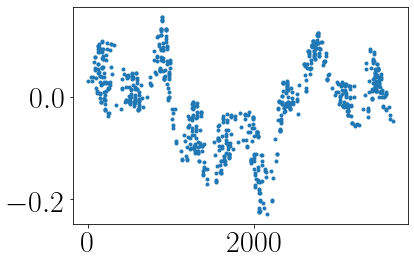

In [23]:
time, _, flux, _ = rr.sim_lc(50, .01, Nvisits=800, tspan=10, seed=2)
yerr = np.ones_like(flux)*1e-4
time -= time[0]
plt.plot(time, flux, ".")

In [24]:
sort = np.argsort(time)
y = np.ascontiguousarray(flux[sort], dtype=np.float64)
yerr = np.ascontiguousarray(yerr[sort], dtype=np.float64)
x = np.ascontiguousarray(time[sort], dtype=np.float64)

In [25]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=100.0, samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
print(peak)

{'index': 1707, 'log_power': -8.636654673218345, 'period': 51.789237719724426, 'period_uncert': 0.5734790035463366}


In [26]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2 * np.log(np.mean(yerr)), sd=2.0)

    # A term to describe the non-periodic variability
    logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y)), sd=5.0)
    logw0 = pm.Normal("logw0", mu=np.log(2 * np.pi / 10), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
    logperiod = BoundedNormal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = xo.distributions.UnitUniform("mix")

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
    kernel += xo.gp.terms.RotationTerm(
        log_amp=logamp, period=period, log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr ** 2 + tt.exp(logs2), mean=mean)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 1091.073730896275 -> 3851.7463593730545


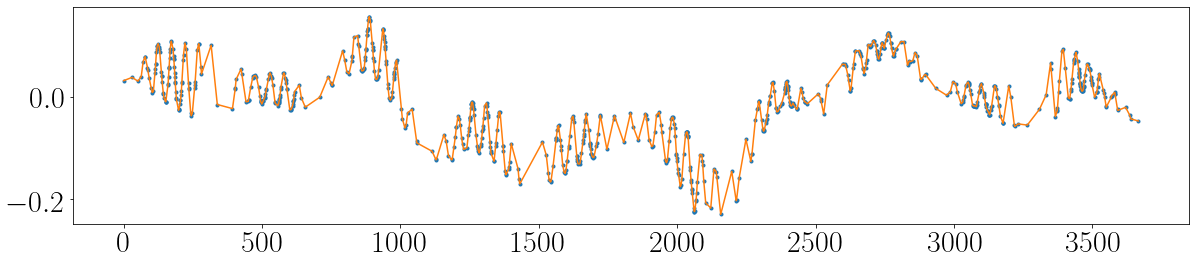

In [27]:
plt.figure(figsize=(20, 4))
plt.plot(time, flux, ".")
plt.plot(x, map_soln["pred"] + map_soln["mean"])

In [28]:
inds = np.array([np.random.randint(0, 5) for i in range(800)])
u, ut = flux[inds == 0], time[inds == 0]
g, gt = flux[inds == 1], time[inds == 1]
r, rt = flux[inds == 2], time[inds == 2]
i, it = flux[inds == 3], time[inds == 3]
z, zt = flux[inds == 4], time[inds == 4]

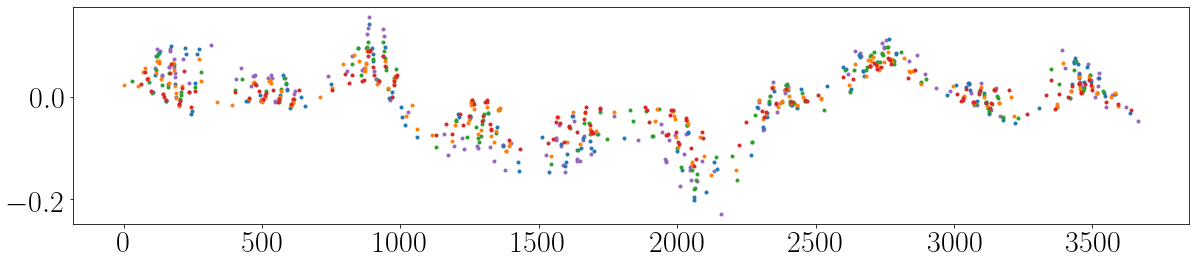

In [29]:
plt.figure(figsize=(20, 4))
plt.plot(ut, u*1, "C4.");
plt.plot(gt, g*.9, "C0.");
plt.plot(rt, r*.8, "C2.");
plt.plot(it, i*.7, "C1.");
plt.plot(zt, z*.6, "C3.");

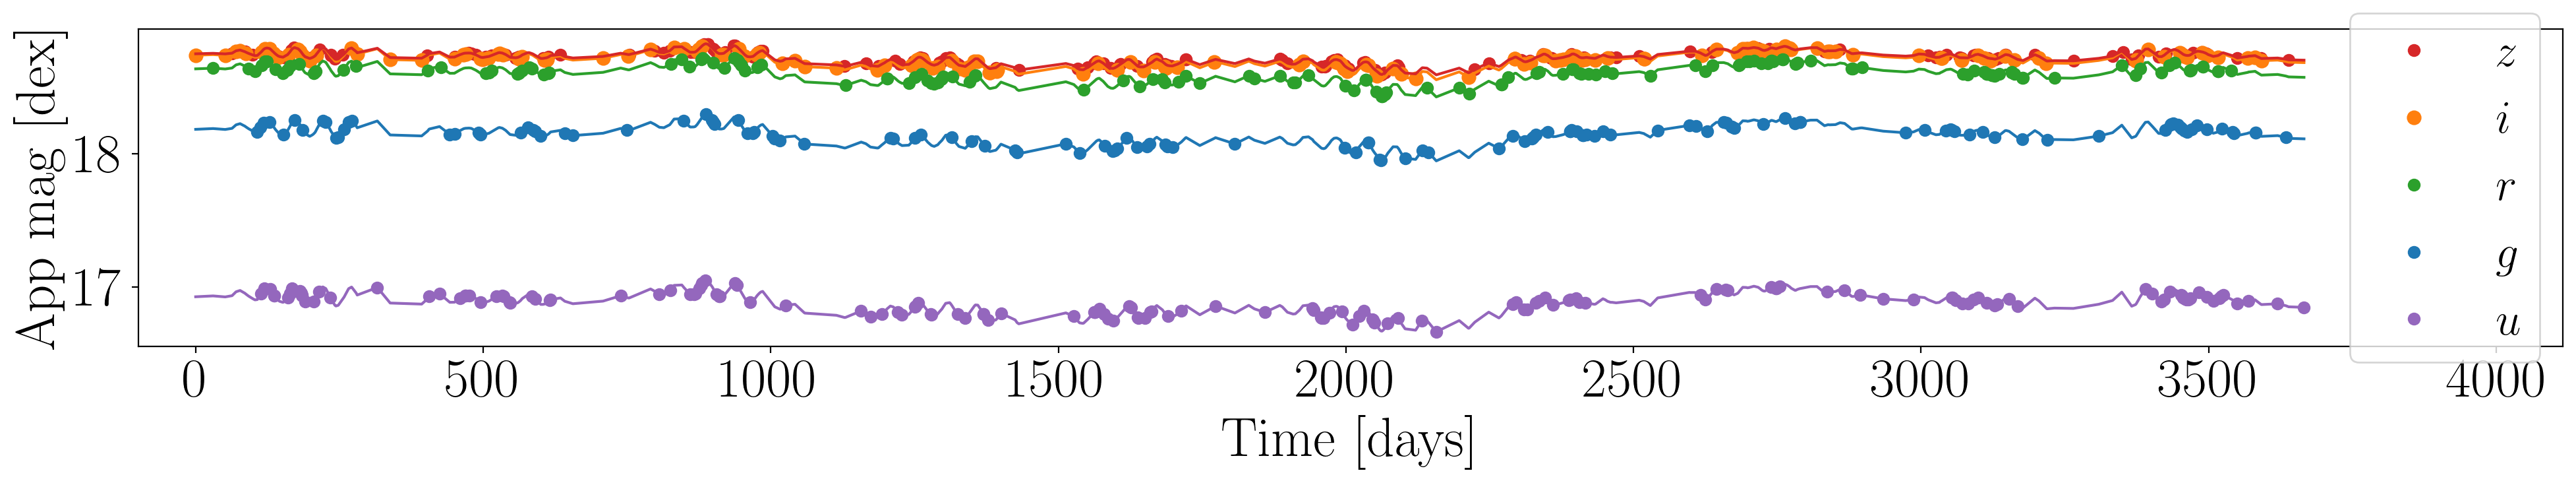

In [58]:
plt.figure(figsize=(20, 4), dpi=200)
plt.plot(zt, z*.6 + zband, "C3o", label="$z$");
plt.plot(it, i*.7 + iband, "C1o", label="$i$", ms=7);
plt.plot(rt, r*.8 + rband, "C2o", label="$r$");
plt.plot(gt, g*.9 + gband, "C0o", label="$g$");
plt.plot(ut, u*1+ uband, "C4o", label="$u$");
plt.legend(loc="right")

plt.plot(time, (map_soln["pred"] + map_soln["mean"]) + uband, "C4")
plt.plot(time, (map_soln["pred"] + map_soln["mean"])*.9 + gband, "C0")
plt.plot(time, (map_soln["pred"] + map_soln["mean"])*.8 + rband, "C2")
plt.plot(time, (map_soln["pred"] + map_soln["mean"])*.7 + iband, "C1")
plt.plot(time, (map_soln["pred"] + map_soln["mean"])*.6 + zband, "C3")
# plt.xlim(0, 2*365)
plt.xlim(-100, max(x)+450)
plt.xlabel("$\mathrm{Time~[days]}$")
plt.ylabel("$\mathrm{App~mag~[dex]}$");
plt.tight_layout()
plt.savefig("multi-band_demo")
plt.savefig("multi-band_demo.pdf")

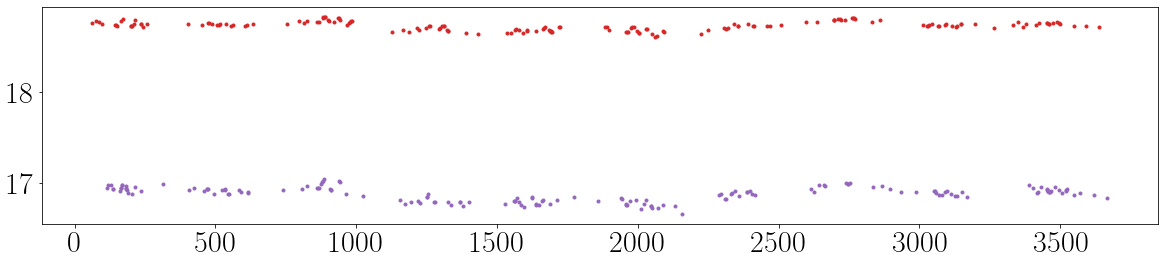

In [31]:
plt.figure(figsize=(20, 4))
plt.plot(ut, u*1+ uband, "C4.");
plt.plot(zt, z*.6 + zband, "C3.");

In [10]:
time = np.concatenate((ut, zt))
flux = np.concatenate((u, z))
uinds, zinds = np.zeros_like(u), np.ones_like(z)
inds = np.concatenate((uinds, zinds))
sort = np.argsort(time)

time = np.ascontiguousarray(time[sort], dtype=np.float64)
flux = np.ascontiguousarray(flux[sort], dtype=np.float64)
inds = np.ascontiguousarray(inds[sort], dtype=np.float64)

In [11]:
star = rr.Star(time, flux, np.ones_like(flux)*1e-6, 50)
map_soln = star.multiband_gp(inds, lower=20, upper=70)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, log_ramp, meanr, mean]


message: NaN result encountered.
logp: nan -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


In [13]:
model = periodic.LombScargleMultibandFast(fit_period=True)
model.optimizer.period_range=(30, 70)

from time import time as t
start = t()
[model.fit(time, flux, np.ones_like(flux)*1e-6, 'uz') for i in range(100)]
end = t()
print((end - start)/100)

Finding optimal frequency:
 - Estimated peak width = 0.00174
 - Using 5 steps per peak; omega_step = 0.000349
 - User-specified period range:  30 to 70
 - Computing periods at 345 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00174
 - Using 5 steps per peak; omega_step = 0.000349
 - User-specified period range:  30 to 70
 - Computing periods at 345 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00174
 - Using 5 steps per peak; omega_step = 0.000349
 - User-specified period range:  30 to 70
 - Computing periods at 345 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00174
 - Using 5 steps per peak; omega_step = 0.000349
 - User-specified period range:  30 to 70
 - Computing periods at 345 steps
Zooming-in on 5 candidate peaks:
 - Computing period

In [21]:
model.best_period

51.566233214314764

In [22]:
tfit = np.linspace(0, model.best_period, 1000)

In [24]:
magfit = model.predict(tfit, filts='uz')

In [30]:
filtsfit = np.array(list('uz'))[:, np.newaxis]
magfit = model.predict(tfit, filts=filtsfit)

# Plot the results
phase = (time / model.best_period) % 1
phasefit = (tfit / model.best_period)

fig, ax = plt.subplots()
for i, filt in enumerate('uz'):
    mask = (filts == filt)
    errorbar = ax.errorbar(phase[mask], flux[mask], np.ones_like(flux)*1e-6[mask], fmt='.')
    ax.plot(phasefit, magfit[i], color=errorbar.lines[0].get_color())
ax.set(xlabel='phase', ylabel='magnitude')
ax.invert_yaxis()

ValueError: filts does not match training data: input: {'uz'} output: {'u', 'z'}